<a href="https://colab.research.google.com/github/NikolaJanik/Polish_poetry_classification_with_transformers/blob/main/ML_and_NN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install dependencies (for Google Colab)

In [1]:
!pip install transformers sacremoses --quiet
!pip install xgboost lightgbm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 16.4 MB/s eta 0:00:00


# 2. Imports

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from transformers import HerbertTokenizer, RobertaModel

# 3. Load and prepare data


In [24]:
df_raw = pd.read_csv('polish_poetry.csv', sep=';')

# Remove 'Unnamed' columns
drop_cols = [col for col in df_raw.columns if 'Unnamed' in col]
df_raw = df_raw.drop(columns=drop_cols)

print("Numbr of poems:", df_raw.shape[0])
print("Number of classes:", df_raw['Label'].nunique())
print("Classes:", df_raw['Author'].unique())

Numbr of poems: 400
Number of classes: 8
Classes: ['Jan Kochanowksi' 'Krzysztof Kamil Baczyński' 'Czesław Miłosz'
 'Zbigniew Herbert' 'Wisława Szymborska' 'Halina Poświatowska'
 'Maria Pawlikowska-Jasnorzewska' 'Ewa Lipska']


# 4. Tokenization and embedding function

In [4]:
def make_embedding(df, model_info):
    model_name, tokenizer, model = model_info
    embeddings = []
    labels = []

    for text, label in tqdm(zip(df['Text'], df['Label']), total=len(df)):
        inputs = tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        outputs = model(**inputs)
        vector = outputs.last_hidden_state[:, 0, :].detach().numpy()[0]
        embeddings.append(vector)
        labels.append(label)

    return np.array(embeddings), np.array(labels)

# 5. HerBERT initialization

In [5]:
herbert = (
    "Herbert",
    HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"),
    RobertaModel.from_pretrained("allegro/herbert-large-cased")
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at allegro/herbert-large-cased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'en

In [6]:
X_all, y_all = make_embedding(df_raw, herbert)


100%|██████████| 400/400 [45:46<00:00,  6.87s/it]


# 7. Prepare X and y sets

In [9]:
def get_splits(X, y, test_size=0.2, val_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)
    return X_train, X_val, X_test, y_train, y_val, y_test



# 8. Machine learning model (Decision Tree)

In [20]:
def run_ml_model_multiple(X, y, model_class, model_name, n_realizations=20, test_size=0.2, val_size=0.2, **model_kwargs):
    num_classes = len(np.unique(y))
    cm_all = np.zeros((num_classes, num_classes, n_realizations))
    scores_all = []

    for r in range(n_realizations):
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y
        )

        # Build ML model
        model = model_class(**model_kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Accuracy and confusion matrix
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, normalize='true')

        cm_all[:, :, r] = cm
        scores_all.append(acc)

    # Mean and std
    cm_mean = cm_all.mean(axis=2)
    cm_std = cm_all.std(axis=2)
    acc_mean = np.mean(scores_all)
    acc_std = np.std(scores_all)

    # Visualization
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean)
    disp.plot()
    plt.title(f"{model_name} | Acc: {acc_mean:.2f} ± {acc_std:.2f}")
    plt.show()

    return acc_mean, acc_std, cm_mean, cm_std

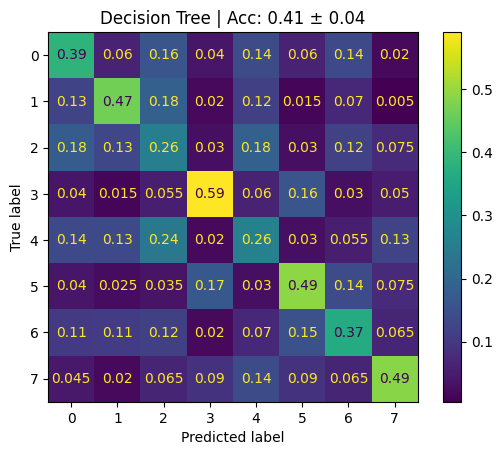

In [21]:
acc_mean, acc_std, cm_mean, cm_std = run_ml_model_multiple(
    X_all, y_all,
    DecisionTreeClassifier,
    "Decision Tree",
    n_realizations=20,
    max_depth=20
)

# 9. Neural network model

In [12]:
def build_nn(input_size, num_classes):
    model = Sequential([
        Dense(input_size, activation='relu', input_shape=(input_size,)),
        Dense(2 * input_size, activation='relu'),
        Dense(4 * input_size, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
n_realizations = 20
epochs = 50
batch_size = 64
num_classes = len(np.unique(y_all))
input_size = X_all.shape[1]

In [14]:
train_loss_all = np.zeros((epochs, n_realizations))
val_loss_all = np.zeros((epochs, n_realizations))
train_acc_all = np.zeros((epochs, n_realizations))
val_acc_all = np.zeros((epochs, n_realizations))
cm_all = np.zeros((num_classes, num_classes, n_realizations))
scores_all = []

In [15]:
for r in range(n_realizations):
    print(f"Realization {r+1}/{n_realizations}")
    X_train, X_val, X_test, y_train, y_val, y_test = get_splits(X_all, y_all)
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    model = build_nn(input_size, num_classes)
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

     # Learning rate
    train_loss_all[:, r] = history.history['loss']
    val_loss_all[:, r] = history.history['val_loss']
    train_acc_all[:, r] = history.history['accuracy']
    val_acc_all[:, r] = history.history['val_accuracy']

    # Test set
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    score = accuracy_score(y_test, y_pred)
    scores_all.append(score)

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_all[:, :, r] = cm

Realizacja 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 4/20
Realizacja 5/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 6/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 7/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 8/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 9/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 10/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 11/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 12/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 13/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 14/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 15/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 16/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 17/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 18/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 19/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Realizacja 20/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 8. Calculate mean and std

In [16]:
train_loss_mean = train_loss_all.mean(axis=1)
val_loss_mean = val_loss_all.mean(axis=1)
train_acc_mean = train_acc_all.mean(axis=1)
val_acc_mean = val_acc_all.mean(axis=1)

train_loss_std = train_loss_all.std(axis=1)
val_loss_std = val_loss_all.std(axis=1)
train_acc_std = train_acc_all.std(axis=1)
val_acc_std = val_acc_all.std(axis=1)

cm_mean = cm_all.mean(axis=2)
cm_std = cm_all.std(axis=2)
score_avg = np.mean(scores_all)

# 10. Learning rate curve

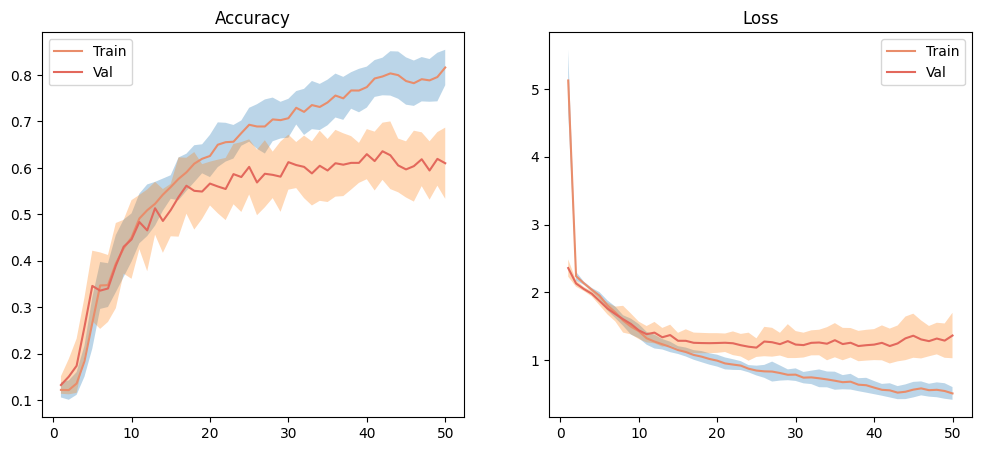

In [17]:
epoch_vec = np.arange(1, epochs+1)
clrs = sns.color_palette("flare")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Accuracy
ax[0].plot(epoch_vec, train_acc_mean, label='Train', color=clrs[0])
ax[0].fill_between(epoch_vec, train_acc_mean-train_acc_std, train_acc_mean+train_acc_std, alpha=0.3)
ax[0].plot(epoch_vec, val_acc_mean, label='Val', color=clrs[1])
ax[0].fill_between(epoch_vec, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std, alpha=0.3)
ax[0].set_title("Accuracy")
ax[0].legend()

# Loss
ax[1].plot(epoch_vec, train_loss_mean, label='Train', color=clrs[0])
ax[1].fill_between(epoch_vec, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=0.3)
ax[1].plot(epoch_vec, val_loss_mean, label='Val', color=clrs[1])
ax[1].fill_between(epoch_vec, val_loss_mean-val_loss_std, val_loss_mean+val_loss_std, alpha=0.3)
ax[1].set_title("Loss")
ax[1].legend()

plt.show()

# 11. Neural network confusion matrix

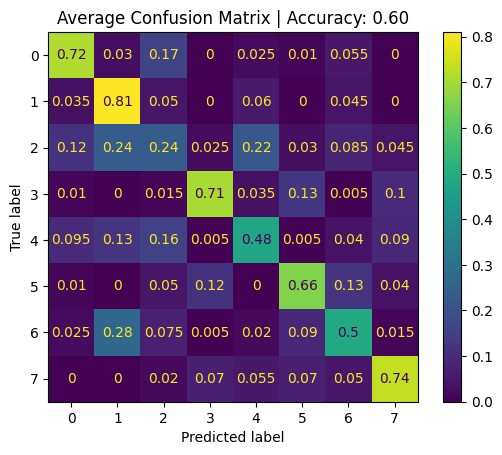

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean)
disp.plot()
plt.title(f"Average Confusion Matrix | Accuracy: {score_avg:.2f}")
plt.show()